In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
import warnings
import math
warnings.filterwarnings(action='ignore', category=FutureWarning)

import custom_dataset as ds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class model_wrapper:
    def __init__(self, model):
        self.model = model
    
    def train_model(self, dataset, epoch, batch_size=16, lr=0.001, decay=0.99):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.model.train()
        for epoch in range(epoch):        
            epoch_loss = 0
            for X, X_t, y, y_t in tqdm(dataloader):
                optimizer.zero_grad()
                X = X.to(self.model.device)
                X_t = X_t.to(self.model.device)

                y_pred = self.model((X, X_t))
                loss = criterion(y_pred.cpu().squeeze(), y.squeeze())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()      

            scheduler.step()
            print(f'Epoch {epoch+1}, MSE Loss: {epoch_loss/len(dataloader)}')
            
    def inference_model(self, dataset, batch_size=16):
        with torch.no_grad():
            self.model.eval()
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            ret = []
            for X, X_t in tqdm(dataloader):
                X = X.to(self.model.device)                  
                X_t = X_t.to(self.model.device)

                '''for i in range(dataset.next_step-1):
                    y_pred = model((X, X_t))
                    X = torch.cat([X[:, 1:], y_pred[:, :1]], dim=1)
                    X_t = torch.remainder(torch.add(X_t, 1), TIME_LEN)'''
                y_pred = self.model((X, X_t))

                '''for i in range(dataset.next_step-1):
                    y_pred = model(y_pred.unsqueeze(1).unsqueeze(1))'''
                ret.append(y_pred.cpu().squeeze(1).squeeze(1))
                #ret.append(y_pred.cpu().squeeze())
        return ret

In [3]:
class SpatialMask(nn.Module):
    def __init__(self, device, mask):
        super(SpatialMask, self).__init__()
        self.device = device
        self.mask = mask
        self.linear = nn.Linear(mask.shape[0], mask.shape[0], device=device, bias=True)
        
    def forward(self, x):
        with torch.no_grad():
            self.linear.weight.data = self.linear.weight.data * self.mask
        return self.linear(x)
        
class SpatialBlock(nn.Module):
    def __init__(self, device, input_channel, output_channel, mask):
        super(SpatialBlock, self).__init__()
        self.device = device
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.spatialmask = SpatialMask(device, mask)
        self.conv1 = nn.Conv2d(input_channel, input_channel, 1, padding=0, device=device)
        self.conv_out = nn.Conv2d(input_channel*2, output_channel, 1, padding=0, device=device)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x2 = self.spatialmask(x)
        x2 = self.relu(x2)
        out = self.conv_out(torch.cat([x1, x2], dim=1))
        out = self.relu(out)
        return out

class TPN(nn.Module):
    def __init__(self, device, mask, prev_len, hidden_channels, depth):
        super(TPN, self).__init__()        
        self.device = device      
        self.mask = mask
        self.prev_len = prev_len
        self.hidden_channels = hidden_channels
        self.depth = depth 
        
        self.first_block = SpatialBlock(device, prev_len*2, hidden_channels, mask)        
        self.spatialblock_list = nn.ModuleList([SpatialBlock(device, prev_len+hidden_channels, hidden_channels, mask) for i in range(depth-1)])
        self.last_conv = nn.Conv2d(hidden_channels, 1, 1, padding=0, device=device)   

        self.time_embedd = nn.Embedding(TIME_LEN, len(self.mask), device=device)

    def forward(self, x):
        x, xt = x        
        xt = self.time_embedd(xt)
        
        x_cur = torch.cat([x, xt], dim=1)
        x_prev = x               
        out_cur = self.first_block(x_cur)
        
        for layer in self.spatialblock_list:
            x_cur = torch.cat([xt, out_cur], dim=1)
            out_cur = layer(x_cur)
        
        out = self.last_conv(out_cur)
        out = nn.ReLU()(out)
        
        
        return out

In [4]:
file_list = []
#file_list.append(('metr-la_train.csv', 'metr-la_train_t.csv', 'metr-la_test.csv', 'metr-la_test_t.csv', 'W_metrla.csv', datetime.datetime(2012, 6, 1)))
file_list.append(('pems-bay_train.csv', 'pems-bay_train_t.csv', 'pems-bay_test.csv', 'pems-bay_test_t.csv', 'W_pemsbay.csv', datetime.datetime(2017, 6, 1)))
file_list.append(('2023_6to9.csv', '2023_6to9_t.csv', '202310.csv', '202310_t.csv', 'W_daegu.csv', datetime.datetime(2023, 10, 1)))

# 환경에 맞게 PATH 수정 / cur_data_idx로 데이터셋 변경(0~2)

In [5]:
PATH = './data/processed_data/traffic/'

cur_data_idx = 0
cur_data = [PATH + i for i in file_list[cur_data_idx][:5]] + [file_list[cur_data_idx][5]]

In [6]:
TIME_LEN = 7*24*12

prev_len = 5
hidden_channels = 80
depth = 5

mask = torch.Tensor(pd.read_csv(cur_data[4]).map(lambda x: 1 if x != 0 else 0).values).to(device)

md = TPN(device, mask, prev_len, hidden_channels, depth)
print(md)

md_wrapper = model_wrapper(md)

TPN(
  (first_block): SpatialBlock(
    (spatialmask): SpatialMask(
      (linear): Linear(in_features=325, out_features=325, bias=True)
    )
    (conv1): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (conv_out): Conv2d(20, 80, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
  )
  (spatialblock_list): ModuleList(
    (0-3): 4 x SpatialBlock(
      (spatialmask): SpatialMask(
        (linear): Linear(in_features=325, out_features=325, bias=True)
      )
      (conv1): Conv2d(85, 85, kernel_size=(1, 1), stride=(1, 1))
      (conv_out): Conv2d(170, 80, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
    )
  )
  (last_conv): Conv2d(80, 1, kernel_size=(1, 1), stride=(1, 1))
  (time_embedd): Embedding(2016, 325)
)


In [7]:
next_step = 12

train_data = ds.Link_Time_Dataset(cur_data[0], cur_data[1], prev_len, next_step)
scaler = train_data.scaler
md_wrapper.train_model(train_data, 25, batch_size=64)

100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:13<00:00, 49.26it/s]


Epoch 1, MSE Loss: 0.01781083801042234


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.36it/s]


Epoch 2, MSE Loss: 0.0036707822592956397


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.67it/s]


Epoch 3, MSE Loss: 0.0033610593383748303


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.44it/s]


Epoch 4, MSE Loss: 0.003192013334345949


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 74.37it/s]


Epoch 5, MSE Loss: 0.0030868643227115493


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 75.56it/s]


Epoch 6, MSE Loss: 0.002993932700380409


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 74.65it/s]


Epoch 7, MSE Loss: 0.0029157113996060454


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 72.64it/s]


Epoch 8, MSE Loss: 0.0028357177805018556


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.19it/s]


Epoch 9, MSE Loss: 0.0027575934290379176


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 70.50it/s]


Epoch 10, MSE Loss: 0.002691189028487048


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 72.54it/s]


Epoch 11, MSE Loss: 0.00263214326593751


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.85it/s]


Epoch 12, MSE Loss: 0.002575910123071962


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 70.09it/s]


Epoch 13, MSE Loss: 0.002517425639876712


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 70.62it/s]


Epoch 14, MSE Loss: 0.002457002512357362


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.95it/s]


Epoch 15, MSE Loss: 0.00240912492000087


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 67.79it/s]


Epoch 16, MSE Loss: 0.002349664270877838


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 69.88it/s]


Epoch 17, MSE Loss: 0.0023044900954974925


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 69.94it/s]


Epoch 18, MSE Loss: 0.002257093567031381


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 72.45it/s]


Epoch 19, MSE Loss: 0.0022116859469165587


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 74.11it/s]


Epoch 20, MSE Loss: 0.0021632776008439526


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.59it/s]


Epoch 21, MSE Loss: 0.0021059260671095485


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 73.67it/s]


Epoch 22, MSE Loss: 0.0020797372754553663


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.28it/s]


Epoch 23, MSE Loss: 0.002033693014870069


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 71.94it/s]


Epoch 24, MSE Loss: 0.001981422343113295


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 73.30it/s]

Epoch 25, MSE Loss: 0.0019483595566057107


In [8]:
inf_data = ds.Link_Time_Dataset(cur_data[2], cur_data[3], prev_len, next_step, get_true=False, scaler=scaler)
ret = md_wrapper.inference_model(inf_data, batch_size=64)

100%|███████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 148.71it/s]


In [9]:
ret

[tensor([[0.8689, 0.8895, 0.8308,  ..., 0.9259, 0.8594, 0.8918],
         [0.8712, 0.8807, 0.8517,  ..., 0.9271, 0.8673, 0.8952],
         [0.8705, 0.8688, 0.8538,  ..., 0.9282, 0.8648, 0.8978],
         ...,
         [0.7484, 0.8852, 0.7862,  ..., 0.8690, 0.8562, 0.8203],
         [0.7232, 0.8863, 0.7834,  ..., 0.8545, 0.8497, 0.7903],
         [0.7444, 0.8898, 0.7654,  ..., 0.8491, 0.8280, 0.7798]]),
 tensor([[0.7547, 0.8912, 0.7540,  ..., 0.8423, 0.8170, 0.7650],
         [0.7842, 0.8911, 0.7537,  ..., 0.8278, 0.7879, 0.7587],
         [0.7130, 0.8942, 0.7583,  ..., 0.8255, 0.7842, 0.7569],
         ...,
         [0.7879, 0.8928, 0.7120,  ..., 0.8890, 0.8459, 0.8690],
         [0.7849, 0.8883, 0.7109,  ..., 0.8817, 0.8456, 0.8626],
         [0.7793, 0.8939, 0.7239,  ..., 0.8841, 0.8422, 0.8664]]),
 tensor([[0.7930, 0.8899, 0.7166,  ..., 0.8836, 0.8432, 0.8678],
         [0.8021, 0.8813, 0.7265,  ..., 0.8866, 0.8415, 0.8676],
         [0.8281, 0.8830, 0.7230,  ..., 0.8870, 0.8416, 0.

In [10]:
result = pd.DataFrame(torch.cat(ret).numpy())

In [11]:
def show_plot(d1, d2):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(d1, 'r', label='Ground Truth')
    ax.plot(d2, 'b', label='Prediction')
    ax.grid(True)
    ax.set_xlabel('Time', loc='right')
    ax.set_ylabel('Speed', loc='top')
    ax.legend()
    
    plt.show()

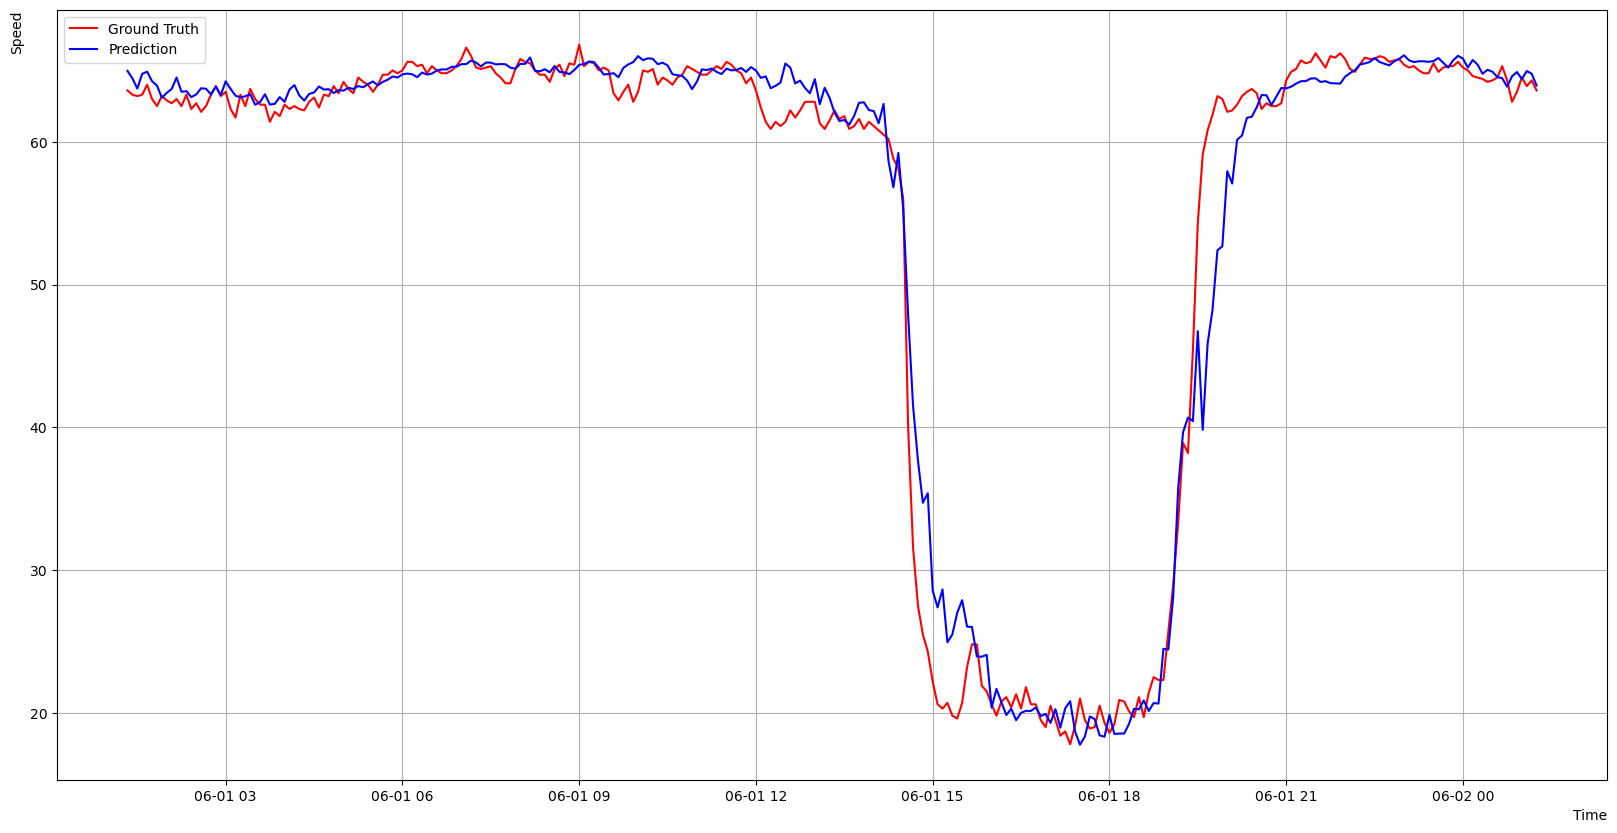

1.48999480009079


In [12]:
d1_start = prev_len + next_step - 1
start_offset = 288*0

time_len = 288 * 1
road_idx = 1

d = pd.read_csv(cur_data[2])
x = [cur_data[5] + i*datetime.timedelta(minutes=5) for i in range(d1_start+start_offset, d1_start+start_offset+time_len)]
d1 = d.iloc[d1_start+start_offset:d1_start+start_offset+time_len, road_idx]
d1 = pd.Series(d1).set_axis(x)
d2 = scaler.inverse_transform(result)[start_offset:time_len+start_offset, road_idx]
d2 = pd.Series(d2).set_axis(x)
show_plot(d1, d2)
print(np.abs((d1-d2)).mean())

In [13]:
mx = 0
mae = []
mse = []
mape = []
for i in range(len(d.iloc[0])):
    d1 = d.iloc[d1_start:, i].reset_index(drop=True)
    d2 = scaler.inverse_transform(result)[:,i]
    err = np.abs(d1-d2)
    print(i, err.mean(), np.sqrt((err**2).mean()))
    mx = max(mx, err.max())
    mae += err.to_list()
    mse += (err**2).to_list()
    mape += (err / d1).tolist()

mae_v = np.array(mae).mean()
rmse_v = np.sqrt(np.array(mse).mean())
mape_v = np.array(mape)
np.place(mape_v, np.isinf(mape_v), [0])
mape_v = mape_v.sum() / np.count_nonzero(mape_v)
print(f'MAX diff: {mx}, MAE: {mae_v}, RMSE: {rmse_v}, MAPE: {mape_v*100}%')

0 2.093504703243942 4.0782021819703775
1 1.8666815579932783 4.505508840936142
2 3.2382051049888907 7.006648544956274
3 2.5001551256551373 4.598014711177382
4 3.1046617616748984 5.61403108693484
5 2.0283881747656274 5.487649519926907
6 3.3851762347628322 6.858653672345292
7 1.860939035964145 4.032082178908561
8 2.7029920462995825 5.485357550332738
9 1.792475740033753 4.2906004834142975
10 5.482372817192537 11.004411433121875
11 2.2209937245151328 5.337218660173298
12 1.2813419710063758 2.6876187343773745
13 2.825048672423071 4.682431204590303
14 1.3412440112437742 2.7911336540774463
15 1.6820203459550365 3.6195645995009547
16 0.9602919612169707 1.872538261521415
17 2.062232087273324 3.931461709089922
18 0.5903957515567927 0.9351993334969594
19 3.5960103011529387 6.823579920186439
20 2.544790203098021 5.4277647243669485
21 2.497823957521088 4.95134019216653
22 1.2996252827830128 2.324444399375188
23 2.7186418240057075 5.031435479578732
24 0.9378846500269337 1.392493596507547
25 1.7247227

207 2.6715229878399054 4.186967479074048
208 2.034173753133289 4.065281856066888
209 1.0371549401079792 1.979754908589076
210 1.99325759269311 4.092603742164192
211 2.316123229408972 4.3746786501453645
212 1.1218089210743807 1.6412111254025088
213 2.596516423809285 5.86019846850506
214 1.7789476744540325 3.1306620233256632
215 1.5654223197908699 2.574927885911064
216 1.6833930408799804 4.133170475072004
217 2.4372645758742086 4.4804217427508215
218 1.4329645681912029 2.7770076908342065
219 2.0141168013132127 4.198927773582442
220 1.4602979275645043 3.0859320124808765
221 1.583641455699871 3.394446046764129
222 1.287169726527467 2.674318279523496
223 1.2486756303535984 2.467344906513463
224 1.7461187172024504 3.625920201208946
225 2.0300179106406246 4.038974213332035
226 2.5233219005181304 5.785262980308056
227 2.6294400356474963 5.841663381375015
228 1.2725352386817859 2.5179271432978645
229 1.78390484333923 3.009341460078399
230 1.9500478271208357 3.942772816494976
231 3.5892815236921